In [96]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import logging

In [70]:
class Logger:

    def __init__(self, file_name: str, basic_level=logging.INFO):

        logger = logging.getLogger(__name__)
        logger.setLevel(basic_level)

        file_handler = logging.FileHandler(f'../logs/{file_name}')
        formatter = logging.Formatter(
            '%(asctime)s : %(levelname)s : %(name)s : %(message)s', '%m-%d-%Y %H:%M:%S')

        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

        self.logger = logger

    def get_app_logger(self) -> logging.Logger:
        return self.logger

In [72]:
logger = Logger("userExperience.log").get_app_logger()
logger.info("Initialized user_experience logger")

In [74]:
class Display_data:
    def __init__(self) -> None:
        self.logger = Logger("plot.log", basic_level=logging.INFO)
        try:
            self.logger = Logger("plot.log").get_app_logger()
            self.logger.info(
                'Successfully Instantiated Preprocessing Class Object')
        except Exception:
            self.logger.exception(
                'Failed to Instantiate Preprocessing Class Object')
            sys.exit(1)

    def display_by_bar(self, df: pd.DataFrame, x_col: str, y_col: str, title: str, xlabel: str, ylabel: str) -> None:
        plt.figure(figsize=(12, 7))
        sns.barplot(data=df, x=x_col, y=y_col)
        plt.title(title, size=20)
        plt.xticks(rotation=75, fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel(xlabel, fontsize=16)
        plt.ylabel(ylabel, fontsize=16)
        self.logger.info(
            'displaying data by bar chart')
        plt.show()

In [54]:
df_exp = pd.read_csv('../data/cleaned_data_outliers.csv')

In [55]:
df = df_exp.copy()

In [90]:
display = Display_data()

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 63 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   bearer_id                                 150001 non-null  float64
 1   start                                     150001 non-null  object 
 2   start_ms                                  150001 non-null  float64
 3   end                                       150001 non-null  object 
 4   end_ms                                    150001 non-null  float64
 5   dur._(ms)                                 150001 non-null  float64
 6   imsi                                      150001 non-null  float64
 7   msisdn/number                             150001 non-null  float64
 8   imei                                      150001 non-null  float64
 9   last_location_name                        150001 non-null  object 
 10  avg_rtt_dl_(ms)     

<AxesSubplot:xlabel='avg_rtt_dl_(ms)'>

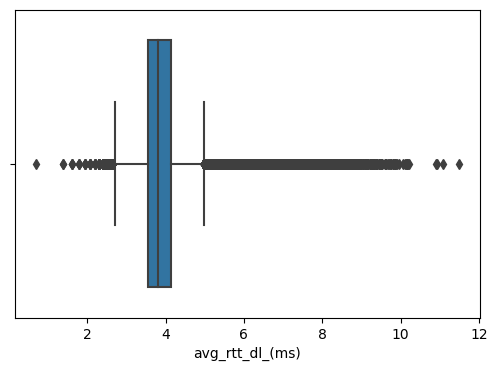

In [77]:
plt.figure(figsize=(6, 4))
sns.boxplot(df['avg_rtt_dl_(ms)'], orient='vert')

In [78]:
user_experience = df[[
    "msisdn/number",
    "avg_rtt_dl_(ms)",
    "avg_rtt_ul_(ms)",
    "avg_bearer_tp_dl_(kbps)",
    "avg_bearer_tp_ul_(kbps)",
    "tcp_dl_retrans._vol_(bytes)",
    "tcp_ul_retrans._vol_(bytes)",
    "handset_type"]]

user_experience['avg_rtt_total'] = user_experience['avg_rtt_dl_(ms)'] + user_experience['avg_rtt_ul_(ms)']
user_experience['avg_bearer_tp_total'] = user_experience['avg_bearer_tp_dl_(kbps)'] + user_experience['avg_bearer_tp_ul_(kbps)']
user_experience['avg_tcp_retrans_total'] = user_experience['tcp_dl_retrans._vol_(bytes)'] + user_experience['tcp_ul_retrans._vol_(bytes)']

In [79]:
user_experience.head()

,msisdn/number,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_dl_retrans._vol_(bytes),tcp_ul_retrans._vol_(bytes),handset_type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,3.366496e+10,3.737670,1.609438,3.135494,3.784190,13.251161,9.94987,Samsung Galaxy A5 Sm-A520F,5.347108,6.919684,23.201031
1,3.368185e+10,4.174387,1.609438,2.772589,3.258097,13.251161,9.94987,Samsung Galaxy J5 (Sm-J530),5.783825,6.030685,23.201031
2,3.376063e+10,3.806662,1.609438,1.791759,2.197225,13.251161,9.94987,Samsung Galaxy A8 (2018),5.416100,3.988984,23.201031
3,3.375034e+10,3.806662,1.609438,3.784190,3.784190,13.251161,9.94987,undefined,5.416100,7.568379,23.201031
4,3.369980e+10,3.806662,1.609438,1.791759,2.197225,13.251161,9.94987,Samsung Sm-G390F,5.416100,3.988984,23.201031


In [80]:
user_experience_agg = user_experience.groupby('msisdn/number').agg({
    'avg_rtt_total': 'sum',
    'avg_bearer_tp_total': 'sum',
    'avg_tcp_retrans_total': 'sum',
    'handset_type': [lambda x: x.mode()[0]]})

user_experience_df = pd.DataFrame()

user_experience_df["avg_rtt_total"] = user_experience_agg["avg_rtt_total"]['sum']
user_experience_df["avg_tp_total"] = user_experience_agg["avg_bearer_tp_total"]['sum']
user_experience_df["total_avg_tcp_total"] = user_experience_agg["avg_tcp_retrans_total"]['sum']
user_experience_df["handset_type"] = user_experience_agg["handset_type"]['<lambda>']
user_experience_df.head()

,avg_rtt_total,avg_tp_total,total_avg_tcp_total,handset_type
msisdn/number,,,,
3.360100e+10,-inf,7.274480,23.201031,Huawei P20 Lite Huawei Nova 3E
3.360100e+10,3.401197,7.803027,23.201031,Apple iPhone 7 (A1778)
3.360100e+10,5.416100,7.763021,23.201031,undefined
3.360101e+10,6.942157,9.102310,16.921539,Apple iPhone 5S (A1457)
3.360101e+10,-inf,27.135851,49.213729,Apple iPhone Se (A1723)


In [81]:
user_experience.head()

,msisdn/number,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_dl_retrans._vol_(bytes),tcp_ul_retrans._vol_(bytes),handset_type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,3.366496e+10,3.737670,1.609438,3.135494,3.784190,13.251161,9.94987,Samsung Galaxy A5 Sm-A520F,5.347108,6.919684,23.201031
1,3.368185e+10,4.174387,1.609438,2.772589,3.258097,13.251161,9.94987,Samsung Galaxy J5 (Sm-J530),5.783825,6.030685,23.201031
2,3.376063e+10,3.806662,1.609438,1.791759,2.197225,13.251161,9.94987,Samsung Galaxy A8 (2018),5.416100,3.988984,23.201031
3,3.375034e+10,3.806662,1.609438,3.784190,3.784190,13.251161,9.94987,undefined,5.416100,7.568379,23.201031
4,3.369980e+10,3.806662,1.609438,1.791759,2.197225,13.251161,9.94987,Samsung Sm-G390F,5.416100,3.988984,23.201031


In [82]:
top_10_tcp = user_experience.nlargest(10, 'avg_bearer_tp_total')['avg_bearer_tp_total']
bottom_10_tcp = user_experience.nsmallest(10, 'avg_bearer_tp_total')['avg_bearer_tp_total']
most_frequent_tcp = user_experience.value_counts('avg_bearer_tp_total').nlargest(10)

[]

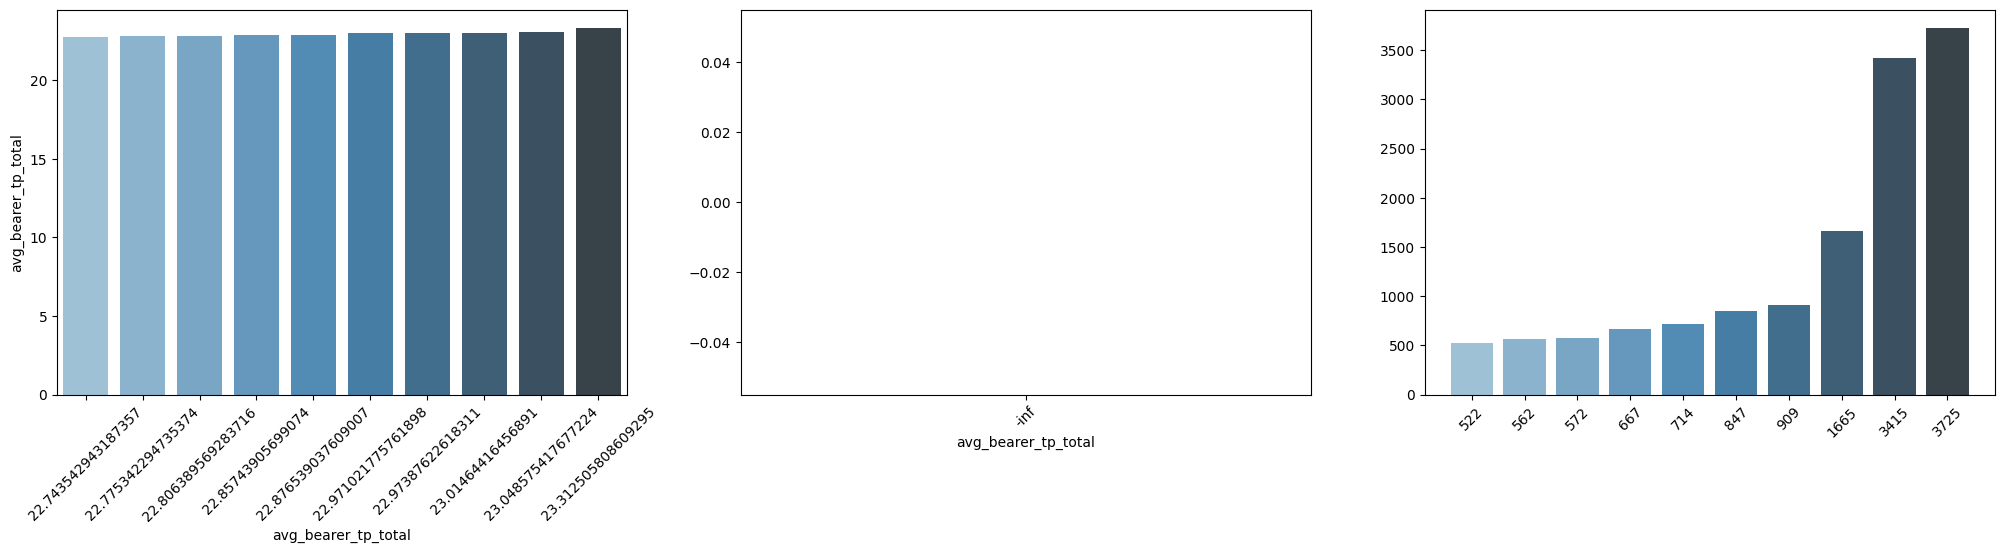

In [83]:
f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_tcp, x=top_10_tcp.index, orient='v', y=top_10_tcp, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_tcp, x=bottom_10_tcp.index,orient='v', y=bottom_10_tcp.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_tcp, x=most_frequent_tcp.index,orient='v', y=most_frequent_tcp.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()

[]

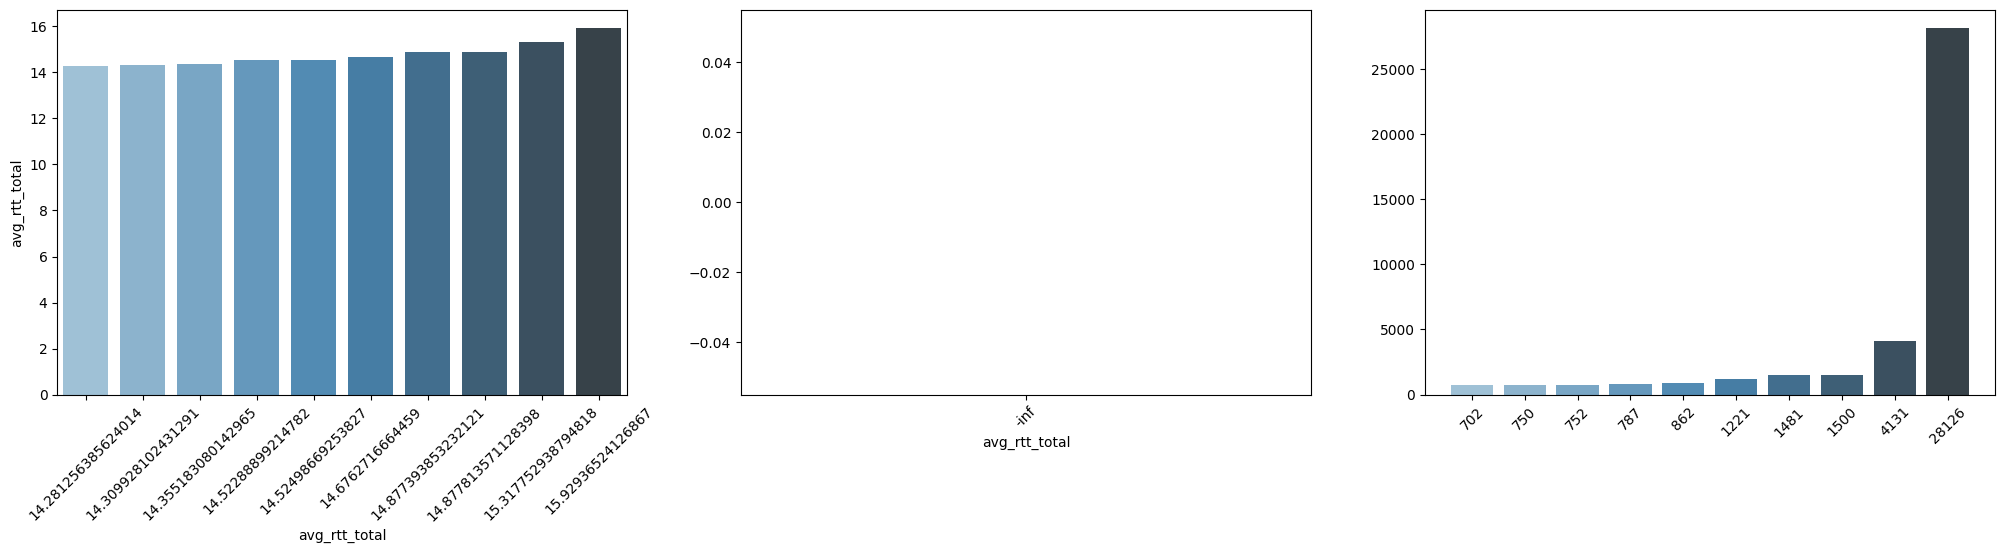

In [84]:
top_10_rtt = user_experience.nlargest(10, 'avg_rtt_total')['avg_rtt_total']
bottom_10_rtt = user_experience.nsmallest(10, 'avg_rtt_total')['avg_rtt_total']
most_frequent_rtt = user_experience.value_counts('avg_rtt_total').nlargest(10)


f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_rtt, x=top_10_rtt.index, orient='v', y=top_10_rtt, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_rtt, x=bottom_10_rtt.index,orient='v', y=bottom_10_rtt.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_rtt, x=most_frequent_rtt.index,orient='v', y=most_frequent_rtt.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()

[]

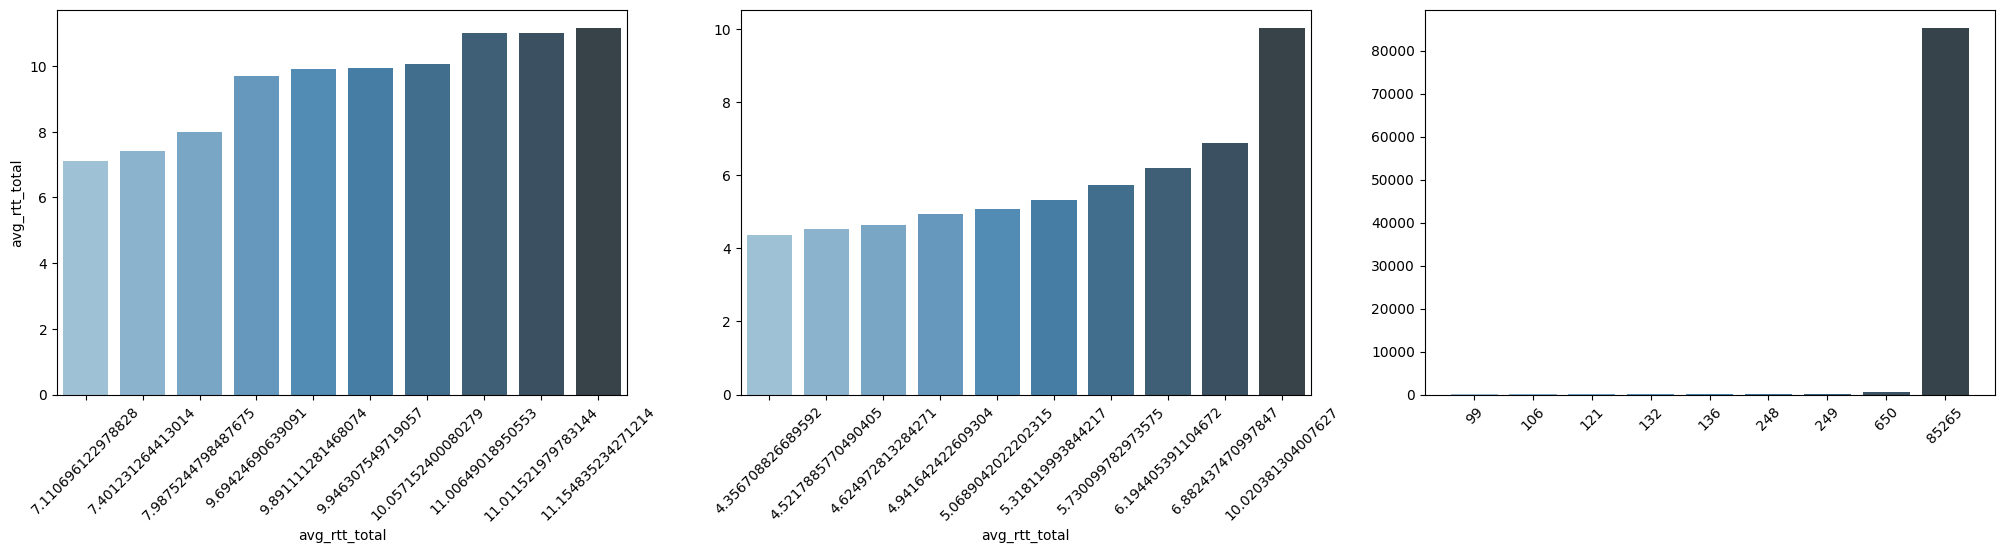

In [85]:
top_10_retrans = user_experience.nlargest(10, 'avg_tcp_retrans_total')['avg_rtt_total']
bottom_10_retrans = user_experience.nsmallest(10, 'avg_tcp_retrans_total')['avg_rtt_total']
most_frequent_retrans = user_experience.value_counts('avg_tcp_retrans_total').nlargest(10)


f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_retrans, x=top_10_retrans.index, orient='v', y=top_10_retrans, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_retrans, x=bottom_10_retrans.index,orient='v', y=bottom_10_retrans.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_retrans, x=most_frequent_retrans.index,orient='v', y=most_frequent_retrans.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()

In [86]:
user_experience.head()

,msisdn/number,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_dl_retrans._vol_(bytes),tcp_ul_retrans._vol_(bytes),handset_type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,3.366496e+10,3.737670,1.609438,3.135494,3.784190,13.251161,9.94987,Samsung Galaxy A5 Sm-A520F,5.347108,6.919684,23.201031
1,3.368185e+10,4.174387,1.609438,2.772589,3.258097,13.251161,9.94987,Samsung Galaxy J5 (Sm-J530),5.783825,6.030685,23.201031
2,3.376063e+10,3.806662,1.609438,1.791759,2.197225,13.251161,9.94987,Samsung Galaxy A8 (2018),5.416100,3.988984,23.201031
3,3.375034e+10,3.806662,1.609438,3.784190,3.784190,13.251161,9.94987,undefined,5.416100,7.568379,23.201031
4,3.369980e+10,3.806662,1.609438,1.791759,2.197225,13.251161,9.94987,Samsung Sm-G390F,5.416100,3.988984,23.201031


In [87]:
handset_type_df = user_experience.groupby('handset_type').agg(
    {'avg_bearer_tp_total': 'mean', 'avg_tcp_retrans_total': 'mean'})
handset_type_df.head()

,avg_bearer_tp_total,avg_tcp_retrans_total
handset_type,,
A-Link Telecom I. Cubot A5,15.838115,23.201031
A-Link Telecom I. Cubot Note Plus,13.931197,22.845643
A-Link Telecom I. Cubot Note S,15.094590,28.653651
A-Link Telecom I. Cubot Nova,17.237061,19.012167
A-Link Telecom I. Cubot Power,16.978497,14.450689


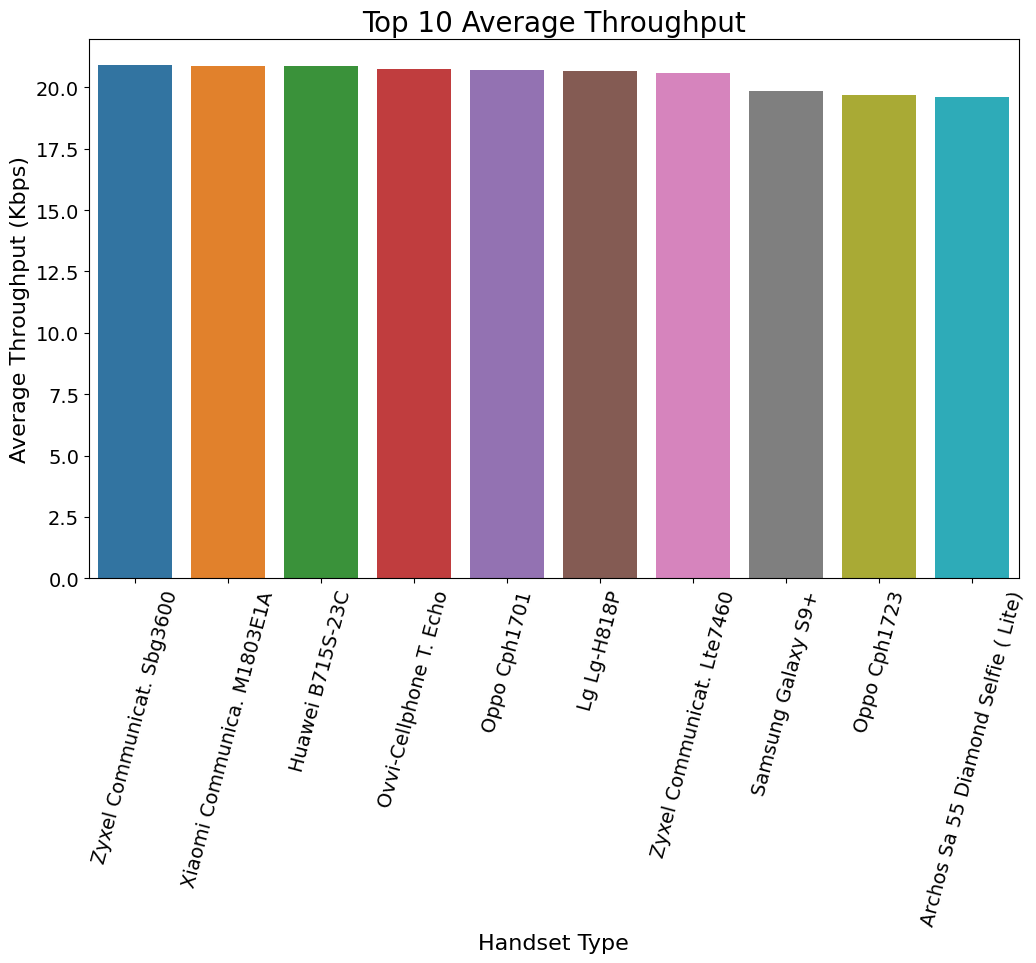

In [92]:
top_tp = handset_type_df.nlargest(10, 'avg_bearer_tp_total')
display.display_by_bar(top_tp ,top_tp.index, top_tp.avg_bearer_tp_total, "Top 10 Average Throughput", "Handset Type", "Average Throughput (Kbps)")

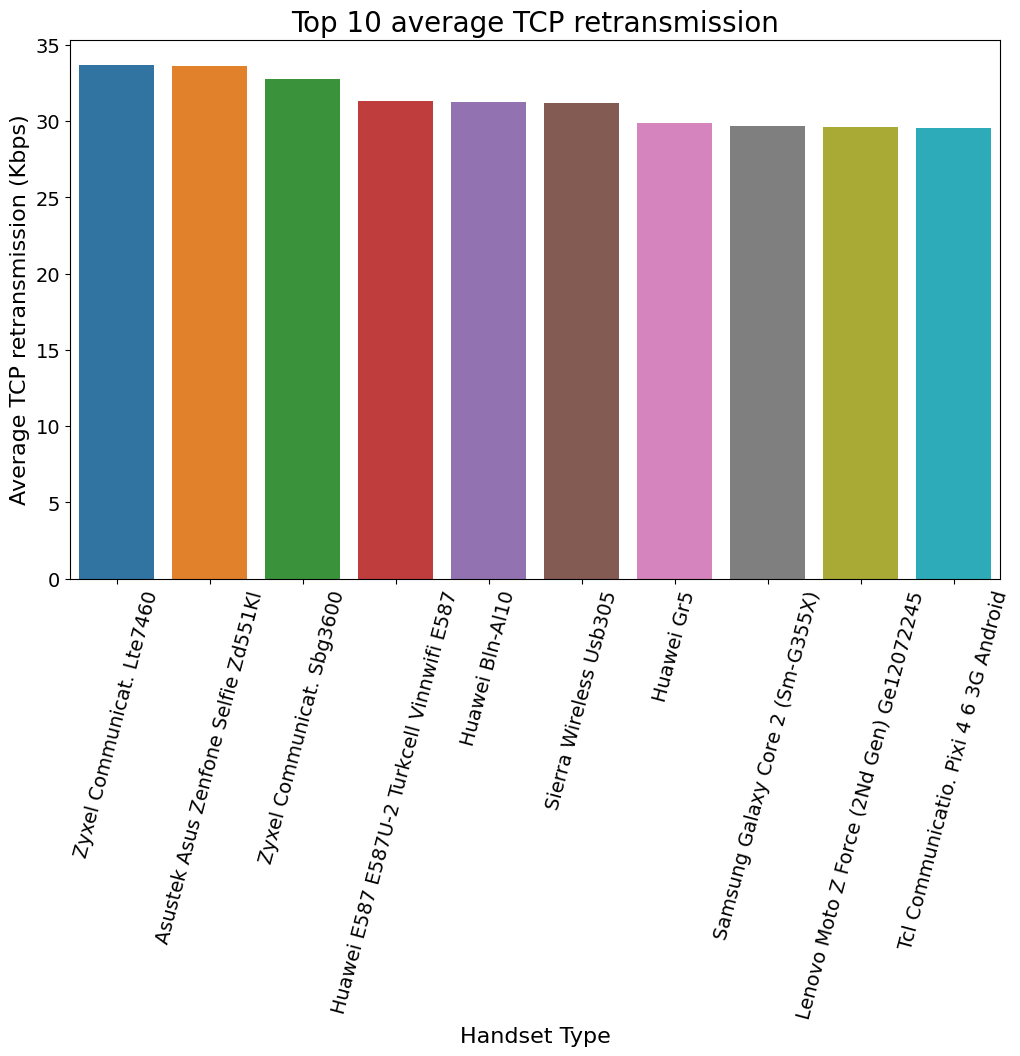

In [94]:
top_tcp = handset_type_df.nlargest(10, 'avg_tcp_retrans_total')
display.display_by_bar(top_tcp ,top_tcp.index, top_tcp.avg_tcp_retrans_total, "Top 10 average TCP retransmission", "Handset Type", "Average TCP retransmission (Kbps)")

In [32]:
user_experience_df.head()

,avg_rtt_total,avg_tp_total,total_avg_tcp_total,handset_type
msisdn/number,,,,
3.360100e+10,-inf,7.274480,23.201031,Huawei P20 Lite Huawei Nova 3E
3.360100e+10,3.401197,7.803027,23.201031,Apple iPhone 7 (A1778)
3.360100e+10,5.416100,7.763021,23.201031,undefined
3.360101e+10,6.942157,9.102310,16.921539,Apple iPhone 5S (A1457)
3.360101e+10,-inf,27.135851,49.213729,Apple iPhone Se (A1723)


In [33]:
user_experience = user_experience_df.drop(['handset_type'], axis=1)

In [34]:
user_experience.replace([np.inf, -np.inf], np.nan, inplace=True)

In [35]:
user_experience.isnull().sum()

avg_rtt_total          4031
avg_tp_total           1427
total_avg_tcp_total       0
dtype: int64

In [36]:
user_experience = user_experience.fillna(user_experience.mean())

In [37]:
def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data 
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

In [38]:
normalized_user_experience = normalizer(user_experience, ['avg_rtt_total',	'avg_tp_total',	'total_avg_tcp_total'] )

In [39]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized_user_experience)
centroids = kmeans.cluster_centers_

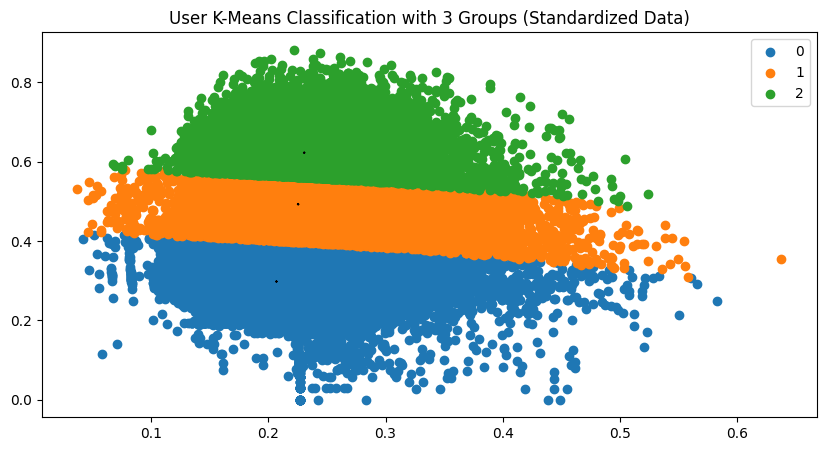

In [95]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 3 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized_user_experience[label == i].iloc[:,0] , normalized_user_experience[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

In [41]:
with open("../models/user_exp.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [43]:
u_exp = user_experience.copy()

In [44]:
u_exp.to_csv('../data/user_experience.csv')

In [45]:
user_experience.to_csv('../data/user_experience.csv')